## Application of ESBM for clustering on simulated data

In [1]:
from pyesbm.model import BaseESBM
from pyesbm.priors import GnedinProcess
from pyesbm.likelihoods import PoissonGamma, BetaBernoulli
from pyesbm.utilities.plotting_functions import plot_heatmap
from pyesbm.utilities.vi_functs import VI
from pyesbm.utilities.data_generation import (
    generate_bernoulli_data,
    generate_poisson_data,
)
import numpy as np

This notebook shows how to use ESBM for clustering simulated data.
ESBM is a Bayesian Non-Parametric Stochastic Block-Model that uses Gibbs-type prior on the clustering structure. The general model can be written as:
$$
\begin{split}
\mathbf{z} &\sim \text{Gibbs-type prior}\\
\theta &\sim \pi(\theta|\eta)\\
y_{ui} \mid \mathbf{z}, \Theta &\sim p(y|\mathbf{z}, \Theta, \xi)
\end{split}
$$
where:
- $p(y|\mathbf{z}, \Theta, \xi)$ is the distribution of the entries of the adjacency matrix depending on the clustering structure $\mathbf{z}$ and possibly some other parameters $\theta, \xi$
- $pi(\cdot, \eta)$ is the prior imposed on $\theta$ possibly depending on some parameters $\eta$
- $\mathbf{z}$ is the partition structure on which we impose a prior of Gibbs-type. The rest of the notebook uses a Gnedin Process (an instance of Gibbs-type) but the code already has implementation for Dirichlet Process, Pittman-Yor Process, the Dirichlet-Multinomial model and it allows the user to specify their own prior sampling scheme.

The rest of the notebook presents an application of clustering using a Beta-Bernoulli model for a unipartite graph and a Poisson-Gamma model for a bipartite graph

## Poisson

In this section we show how to use ESBM for count-type data on a bipartite graph. In this case the easy choice for likelihood-prior is the a Poisson-Gamma model and we can simply ue two cluster assignment vector (one for each "side" of the network):
$$
\begin{split}
\mathbf{z}, \mathbf{q} &\sim \text{Gibbs-type prior}\\
\theta_{h, k}|a, b &\sim \text{Gamma}(a, b)\\
y_ui \mid z, q, \Theta &\sim \text{Poisson}(\theta_{h, k})
\end{split}
$$

In [2]:
n = 100
n2 = 150

rng = np.random.default_rng(1)

# manually define cluster sizes and assignments
sizes_1 = [
    n // 5,
    n // 10,
    n // 3,
    n // 4,
    n - (n // 3) - (n // 4) - (n // 5) - (n // 10),
]

clustering_1 = np.array(
    [0 for _ in range(sizes_1[0])]
    + [1 for _ in range(sizes_1[1])]
    + [2 for _ in range(sizes_1[2])]
    + [3 for _ in range(sizes_1[3])]
    + [4 for _ in range(sizes_1[4])]
)

# manually define cluster sizes and assignments
sizes_2 = [n2 // 4, n2 // 4, n2 // 5, n2 - (n2 // 4) - (n2 // 4) - (n2 // 5)]

clustering_2 = np.array(
    [0 for _ in range(sizes_2[0])]
    + [1 for _ in range(sizes_2[1])]
    + [2 for _ in range(sizes_2[2])]
    + [3 for _ in range(sizes_2[3])]
)

# generate bipartite Poisson data
Y = generate_poisson_data(
    1, 1, clustering_1, clustering_2=clustering_2, bipartite=True, rng=rng
)

# shuffle the adjacency matrix and cluster assignments
a = rng.permutation(n)
b = rng.permutation(n2)
clustering_1 = clustering_1[a]
clustering_2 = clustering_2[b]
Y = Y[a][:, b]

Here we instantiate the model with Gnedin Process prior. Note that using`GnedinProcess()` is equivalent to `GibbsTypePrior(scheme_type='GN')`.

For this toy example we will use a $Gamma(1, 1)$ prior and set the $\gamma$ parameter for Gnedin Process to $0.5$. For a real data analysis we would like to set these to achieve certain properties such as having reasonable (usually conservative) expected a priori number of clusters.

As shown below with $gamma=0.5$ we get that this expected value is $\approx 9$ 

In [3]:
prior_shape = 1
prior_rate = 1
gamma = 0.5
epsilon = 1e-10

prior = GnedinProcess(gamma=gamma)
likelihood = PoissonGamma(shape=prior_shape, rate=prior_rate)

prior.expected_num_clusters(n)

np.float64(8.873353971415057)

The cell below shows the log-likelihood for the true partition and its adjacency matrix.

-7691.127948300976


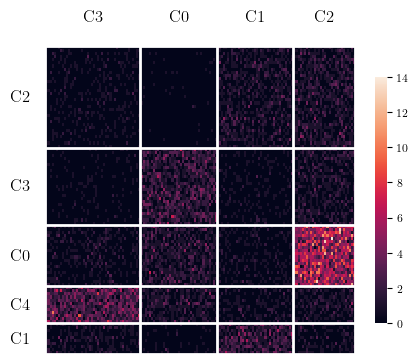

In [4]:
gen_model = BaseESBM(
    Y,
    prior=prior,
    clustering=[clustering_1, clustering_2],
    likelihood=likelihood,
    epsilon=1e-10,
    bipartite=True,
    verbose=False,
    rng=rng,
)

print(gen_model.compute_log_likelihood())
plot_heatmap(gen_model, size=(5, 4), bipartite=True, triangular_mask=False)

**Instantiate and fit the model**

Here we're running a collapsed Gibbs sampler where we sample only the cluster assignment for each nodes. For this example we use only 200 iterations since in this case this is enough to get convergence (in practice we would probably need to take a much higher number of samples).

The model is initialised with a draw from the prior. The class allows to specify a specific clustering by passing a list/np.array. If left to None the model is initialised with one cluster per node.

In [5]:
rng = np.random.default_rng(2)

poisson_model = BaseESBM(
    Y,
    prior=prior,
    likelihood=likelihood,
    epsilon=1e-10,
    bipartite=True,
    verbose=False,
    clustering="Random",
    rng=rng,
)

# plot_heatmap(poisson_model, size=(6, 5), bipartite=True, triangular_mask=False)

out = poisson_model.fit(n_iters=200, verbose=True)

starting log likelihood -14836.863986594239
0 -10663.019951209668
time 0.05103612499078736
20 -7695.814346216658
time 1.1499436250305735
40 -7699.987583639695
time 1.2048616660176776
60 -7690.838657593684
time 1.1450077499612235
80 -7689.961929995689
time 1.2193420000257902
100 -7691.127948300974
time 1.085602209030185
120 -7691.127948300974
time 1.0208727499702945
140 -7691.127948300974
time 1.0148862090427428
160 -7691.127948300974
time 1.007640249968972
180 -7691.127948300974
time 1.0289510829607025
end llk:  -7691.127948300974


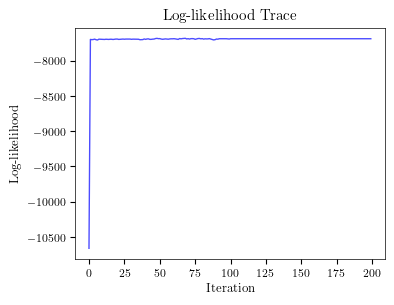

In [6]:
poisson_model.plot_trace(start=1, figsize=(4, 3))

We can now use the VI metric to estimate the clustering structure from the posterior draws (see  Wade and Ghahramani, 2018 for details on how this is done).

To estimarte how far our partition is from the true structure we can again use the VI metric itself or a graphical analysis.

From the output below we see that the model recovers the partitioning structure almost perfectly.

[0.] [0.]


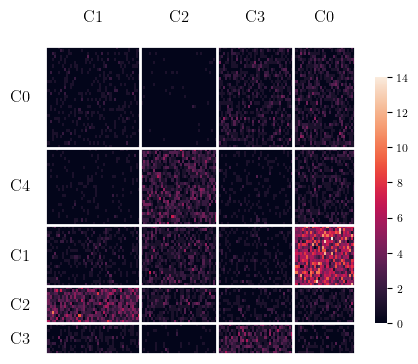

In [7]:
estimated = poisson_model.estimate_cluster_assignment_vi(burn_in=20)
cl1 = estimated[0]
cl2 = estimated[2]
print(VI(clustering_1, cl1), VI(clustering_2, cl2))

plot_heatmap(poisson_model, size=(5, 4), bipartite=True, triangular_mask=True)

### Bernoulli

We can repeat the same analysis using a Beta-Bernoulli model of the form:
$$
\begin{split}
\mathbf{z} &\sim \text{Gibbs-type prior}\\
\theta_{h, k}|a, b &\sim \text{Beta}(a, b)\\
y_{ui} \mid \mathbf{z}, \Theta &\sim \text{Bernoulli}(\theta_{h, k})
\end{split}
$$

-4280.345683824741


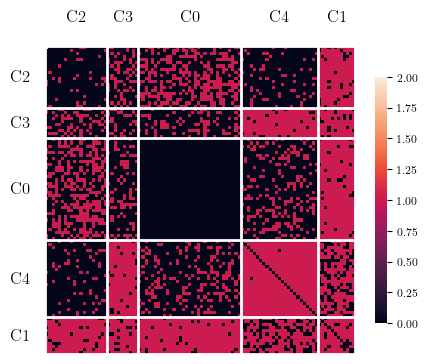

In [8]:
n = 100

rng = np.random.default_rng(3)

sizes = [
    n // 5,
    n // 10,
    n // 3,
    n // 4,
    n - (n // 3) - (n // 4) - (n // 5) - (n // 10),
]

clustering = np.array(
    [0 for _ in range(sizes[0])]
    + [1 for _ in range(sizes[1])]
    + [2 for _ in range(sizes[2])]
    + [3 for _ in range(sizes[3])]
    + [4 for _ in range(sizes[4])]
)

Y = generate_bernoulli_data(0.5, 0.5, clustering, bipartite=False, rng=rng)

a = rng.permutation(n)
clustering = clustering[a]
Y = Y[a][:, a]

prior_alpha = 1
prior_beta = 1

prior = GnedinProcess(gamma=0.5)
likelihood = BetaBernoulli(alpha=prior_alpha, beta=prior_beta)

gen_model = BaseESBM(
    Y,
    prior=prior,
    clustering=clustering,
    likelihood=likelihood,
    epsilon=1e-10,
    bipartite=False,
    verbose=False,
    rng=rng,
)

print(gen_model.compute_log_likelihood())
plot_heatmap(gen_model, size=(5, 4), bipartite=False, triangular_mask=False)

In [9]:
rng = np.random.default_rng(4)

bernoulli_model = BaseESBM(
    Y,
    prior=prior,
    likelihood=likelihood,
    epsilon=1e-10,
    bipartite=False,
    verbose=False,
    clustering="Random",
    rng=rng,
)

# plot_heatmap(bernoulli_model, size=(6, 5), bipartite=False, triangular_mask=False)

out = bernoulli_model.fit(n_iters=200, verbose=True)

starting log likelihood -6803.69801937916
0 -4799.462228736242
time 0.09042275004321709
20 -4295.22842957208
time 0.47392641694750637
40 -4291.246228598049
time 0.42413449997548014
60 -4296.645193669636
time 0.3998255420010537
80 -4284.331366434714
time 0.39929920801660046
100 -4284.331366434714
time 0.43848195899045095
120 -4291.451528197516
time 0.4120177500299178
140 -4280.34568382474
time 0.3828197920229286
160 -4280.34568382474
time 0.3629889999865554
180 -4280.34568382474
time 0.35056412499397993
end llk:  -4280.34568382474


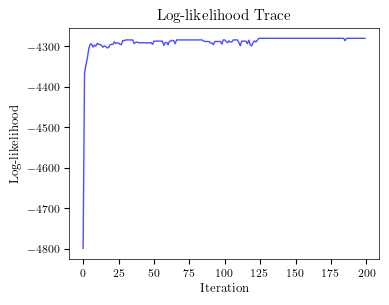

In [10]:
bernoulli_model.plot_trace(start=1, figsize=(4, 3))

[0.]


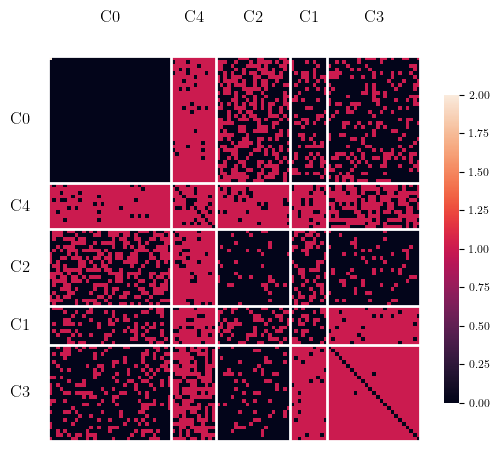

In [11]:
estimated = bernoulli_model.estimate_cluster_assignment_vi(burn_in=20)
cl1 = estimated[0]
print(VI(clustering, cl1))

plot_heatmap(bernoulli_model, size=(6, 5), bipartite=False, triangular_mask=False)